In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Data Loader

In [34]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy') 
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')


test_size = 20/100
X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

initial_labeled = 100
initial_labeled= 1-initial_labeled/len(X_pool)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=initial_labeled, stratify=y_pool, random_state=42)


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_labeled shape: {X_labeled.shape}")
print(f"y_labeled shape: {y_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")
print(f"y_unlabeled shape: {y_unlabeled.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val  shape: {y_val .shape}")
print(f"X_pool shape: {X_pool.shape}")
print(f"y_pool  shape: {y_pool .shape}")


X shape: (20000, 6, 28)
y shape: (20000,)
X_labeled shape: (100, 6, 28)
y_labeled shape: (100,)
X_unlabeled shape: (15900, 6, 28)
y_unlabeled shape: (15900,)
X_val shape: (4000, 6, 28)
y_val  shape: (4000,)
X_pool shape: (16000, 6, 28)
y_pool  shape: (16000,)


In [35]:
y_sample = y
X_sample = X

# Label distribution
label_counts = Counter(y_sample)
df_labels = pd.DataFrame.from_dict(label_counts, orient='index').sort_index()
df_labels.columns = ['count']
df_labels['percent'] = 100 * df_labels['count'] / len(y_sample)
print("\nLabel distribution:")
print(df_labels)

channel_variance = np.var(X_sample, axis=2).mean(axis=0)
channel_mean = X_sample.mean(axis=(0, 2))
channel_std = X_sample.std(axis=(0, 2))
df_stats = pd.DataFrame({
    'channel': range(6),
    'mean': channel_mean,
    'std_dev': channel_std,
    'variance': channel_variance
})
print("\nMean, Std Dev and Variance per Channel:")
print(df_stats)


Label distribution:
   count  percent
0   9081   45.405
1   2603   13.015
2   8316   41.580

Mean, Std Dev and Variance per Channel:
   channel      mean   std_dev  variance
0        0  0.004546  0.999189  0.730689
1        1  0.004955  0.999538  0.721030
2        2  0.003958  1.000457  0.755685
3        3  0.001807  1.000751  0.783507
4        4  0.001153  1.000271  0.634434
5        5  0.001723  1.000909  0.731176


In [36]:
# Total number of samples
total_samples = sum(label_counts.values())

# Number of classes
num_classes = max(label_counts.keys()) + 1  # assuming labels start from 0

# Compute weight for each class as inverse frequency
class_weights = []
for i in range(num_classes):
    count = label_counts.get(i, 0)
    if count == 0:
        class_weights.append(0.0)  # or very small value like 1e-6
    else:
        class_weights.append(total_samples / (num_classes * count))

# Convert to torch tensor for CE loss
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


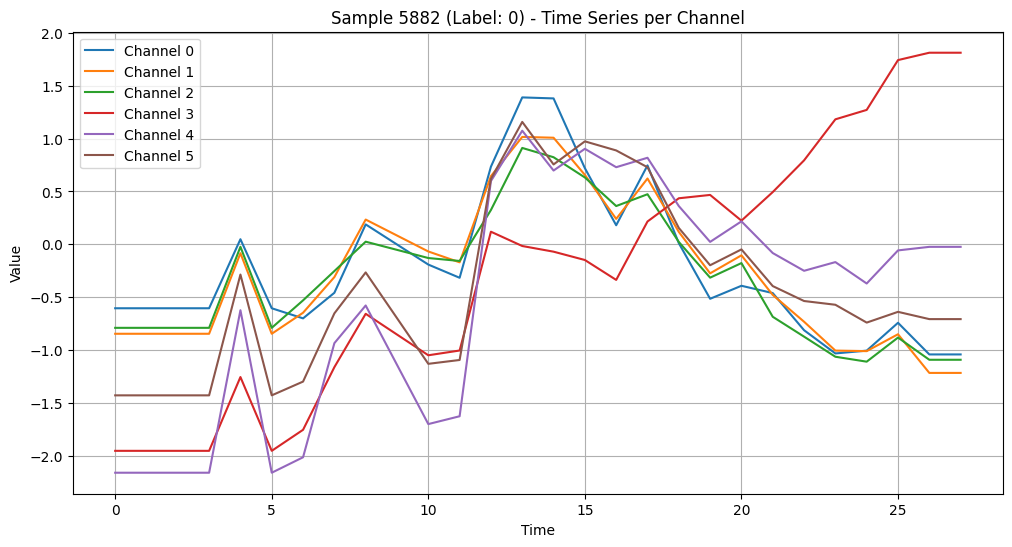

In [37]:
i = np.random.randint(0, len(X))
sample = X[i]  # Shape: (6, T)

plt.figure(figsize=(12, 6))
for c in range(6):
    plt.plot(sample[c], label=f'Channel {c}')
plt.title(f"Sample {i} (Label: {y[i]}) - Time Series per Channel")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Dataloader

In [38]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

In [39]:
train_dataset = Dataset(X_pool, y_pool)
val_dataset = Dataset(X_val, y_val)

# Model

In [40]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int, dropout=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5, padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

 
################ Fully connected network
class FC(nn.Module):
    def __init__(self, input_dim):
        super(FC, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fco(x)
        return x



class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

# Loading weights

In [41]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)

# Train/eval loop

In [42]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []

    for batch in tqdm(dataloader, desc="Training", leave=False):
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, criterion=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validating', leave=False):
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if criterion:
                total_loss += criterion(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if criterion:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1



# Active Learning Loop

In [43]:
def plot_round_metrics(history):
    round_id = len(history["epoch_metrics"]) - 1
    epoch_stats = history["epoch_metrics"][round_id]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id+1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id+1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id+1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()



Epoch 1/50


Train   | Loss: 0.9864 | Acc: 0.6989 | Avg F1: 0.6834


Val     | Loss: 0.4304 | Acc: 0.8565 | Avg F1: 0.8564

Epoch 2/50


Train   | Loss: 0.5160 | Acc: 0.8000 | Avg F1: 0.7995


Val     | Loss: 0.4149 | Acc: 0.8508 | Avg F1: 0.8561

Epoch 3/50


Train   | Loss: 0.4366 | Acc: 0.8226 | Avg F1: 0.8242


Val     | Loss: 0.3628 | Acc: 0.8662 | Avg F1: 0.8674

Epoch 4/50


Train   | Loss: 0.4022 | Acc: 0.8363 | Avg F1: 0.8355


Val     | Loss: 0.3906 | Acc: 0.8635 | Avg F1: 0.8653

Epoch 5/50


Train   | Loss: 0.3693 | Acc: 0.8446 | Avg F1: 0.8441


Val     | Loss: 0.3267 | Acc: 0.8748 | Avg F1: 0.8743

Epoch 6/50


Train   | Loss: 0.3537 | Acc: 0.8530 | Avg F1: 0.8520


Val     | Loss: 0.4069 | Acc: 0.8610 | Avg F1: 0.8654

Epoch 7/50


Train   | Loss: 0.3372 | Acc: 0.8599 | Avg F1: 0.8586


Val     | Loss: 0.3461 | Acc: 0.8798 | Avg F1: 0.8800

Epoch 8/50


Train   | Loss: 0.3327 | Acc: 0.8579 | Avg F1: 0.8571


Val     | Loss: 0.3577 | Acc: 0.8730 | Avg F1: 0.8762

Epoch 9/50


Train   | Loss: 0.3267 | Acc: 0.8644 | Avg F1: 0.8626


Val     | Loss: 0.3459 | Acc: 0.8770 | Avg F1: 0.8784

Epoch 10/50


Train   | Loss: 0.3216 | Acc: 0.8656 | Avg F1: 0.8648


Val     | Loss: 0.3507 | Acc: 0.8798 | Avg F1: 0.8796

Epoch 11/50


Train   | Loss: 0.3135 | Acc: 0.8676 | Avg F1: 0.8660


Val     | Loss: 0.3259 | Acc: 0.8790 | Avg F1: 0.8772

Epoch 12/50


Train   | Loss: 0.3063 | Acc: 0.8689 | Avg F1: 0.8665


Val     | Loss: 0.3436 | Acc: 0.8822 | Avg F1: 0.8847

Epoch 13/50


Train   | Loss: 0.3103 | Acc: 0.8724 | Avg F1: 0.8704


Val     | Loss: 0.3334 | Acc: 0.8748 | Avg F1: 0.8746

Epoch 14/50


Train   | Loss: 0.2965 | Acc: 0.8730 | Avg F1: 0.8712


Val     | Loss: 0.2993 | Acc: 0.8878 | Avg F1: 0.8880

Epoch 15/50


Train   | Loss: 0.2861 | Acc: 0.8799 | Avg F1: 0.8775


Val     | Loss: 0.3121 | Acc: 0.8848 | Avg F1: 0.8840

Epoch 16/50


Train   | Loss: 0.2884 | Acc: 0.8788 | Avg F1: 0.8774


Val     | Loss: 0.3003 | Acc: 0.8875 | Avg F1: 0.8856

Epoch 17/50


Train   | Loss: 0.2860 | Acc: 0.8750 | Avg F1: 0.8740


Val     | Loss: 0.3077 | Acc: 0.8872 | Avg F1: 0.8880

Epoch 18/50


Train   | Loss: 0.2812 | Acc: 0.8799 | Avg F1: 0.8778


Val     | Loss: 0.2878 | Acc: 0.8838 | Avg F1: 0.8783

Epoch 19/50


Train   | Loss: 0.2808 | Acc: 0.8795 | Avg F1: 0.8764


Val     | Loss: 0.2999 | Acc: 0.8952 | Avg F1: 0.8957

Epoch 20/50


Train   | Loss: 0.2756 | Acc: 0.8826 | Avg F1: 0.8810


Val     | Loss: 0.2983 | Acc: 0.8945 | Avg F1: 0.8932

Epoch 21/50


Train   | Loss: 0.2788 | Acc: 0.8819 | Avg F1: 0.8799


Val     | Loss: 0.2914 | Acc: 0.8920 | Avg F1: 0.8890

Epoch 22/50


Train   | Loss: 0.2734 | Acc: 0.8826 | Avg F1: 0.8790


Val     | Loss: 0.3244 | Acc: 0.8798 | Avg F1: 0.8808

Epoch 23/50


Train   | Loss: 0.2661 | Acc: 0.8869 | Avg F1: 0.8852


Val     | Loss: 0.2991 | Acc: 0.8925 | Avg F1: 0.8938

Epoch 24/50


Train   | Loss: 0.2626 | Acc: 0.8879 | Avg F1: 0.8868


Val     | Loss: 0.3120 | Acc: 0.8955 | Avg F1: 0.8979

Epoch 25/50


Train   | Loss: 0.2616 | Acc: 0.8878 | Avg F1: 0.8853


Val     | Loss: 0.3030 | Acc: 0.8862 | Avg F1: 0.8818

Epoch 26/50


Train   | Loss: 0.2554 | Acc: 0.8918 | Avg F1: 0.8904


Val     | Loss: 0.3152 | Acc: 0.8930 | Avg F1: 0.8934

Epoch 27/50


Train   | Loss: 0.2552 | Acc: 0.8905 | Avg F1: 0.8887


Val     | Loss: 0.2980 | Acc: 0.8875 | Avg F1: 0.8826

Epoch 28/50


Train   | Loss: 0.2581 | Acc: 0.8890 | Avg F1: 0.8877


Val     | Loss: 0.3117 | Acc: 0.8948 | Avg F1: 0.8965

Epoch 29/50


Train   | Loss: 0.2513 | Acc: 0.8902 | Avg F1: 0.8891


Val     | Loss: 0.3010 | Acc: 0.8942 | Avg F1: 0.8926

Epoch 30/50


Train   | Loss: 0.2506 | Acc: 0.8926 | Avg F1: 0.8905


Val     | Loss: 0.3062 | Acc: 0.8912 | Avg F1: 0.8917

Epoch 31/50


Train   | Loss: 0.2482 | Acc: 0.8934 | Avg F1: 0.8911


Val     | Loss: 0.3002 | Acc: 0.8985 | Avg F1: 0.9005

Epoch 32/50


Train   | Loss: 0.2439 | Acc: 0.8942 | Avg F1: 0.8927


Val     | Loss: 0.3067 | Acc: 0.8948 | Avg F1: 0.8962

Epoch 33/50


Train   | Loss: 0.2471 | Acc: 0.8911 | Avg F1: 0.8898


Val     | Loss: 0.2993 | Acc: 0.8938 | Avg F1: 0.8903

Epoch 34/50


Train   | Loss: 0.2423 | Acc: 0.8934 | Avg F1: 0.8914


Val     | Loss: 0.3296 | Acc: 0.8898 | Avg F1: 0.8897

Epoch 35/50


Train   | Loss: 0.2411 | Acc: 0.8972 | Avg F1: 0.8949


Val     | Loss: 0.2974 | Acc: 0.8922 | Avg F1: 0.8899

Epoch 36/50


Train   | Loss: 0.2453 | Acc: 0.8951 | Avg F1: 0.8923


Val     | Loss: 0.2920 | Acc: 0.8938 | Avg F1: 0.8913

Epoch 37/50


Train   | Loss: 0.2356 | Acc: 0.8975 | Avg F1: 0.8963


Val     | Loss: 0.2881 | Acc: 0.8872 | Avg F1: 0.8783

Epoch 38/50


Train   | Loss: 0.2344 | Acc: 0.8968 | Avg F1: 0.8952


Val     | Loss: 0.3001 | Acc: 0.8968 | Avg F1: 0.8966

Epoch 39/50


Train   | Loss: 0.2336 | Acc: 0.8979 | Avg F1: 0.8965


Val     | Loss: 0.2911 | Acc: 0.8900 | Avg F1: 0.8874

Epoch 40/50


Train   | Loss: 0.2349 | Acc: 0.8977 | Avg F1: 0.8955


Val     | Loss: 0.2821 | Acc: 0.8912 | Avg F1: 0.8858

Epoch 41/50


Train   | Loss: 0.2316 | Acc: 0.9023 | Avg F1: 0.9009


Val     | Loss: 0.2905 | Acc: 0.8952 | Avg F1: 0.8943

Epoch 42/50


Train   | Loss: 0.2261 | Acc: 0.9004 | Avg F1: 0.9002


Val     | Loss: 0.3010 | Acc: 0.8918 | Avg F1: 0.8863

Epoch 43/50


Train   | Loss: 0.2291 | Acc: 0.9005 | Avg F1: 0.8992


Val     | Loss: 0.3007 | Acc: 0.8942 | Avg F1: 0.8925

Epoch 44/50


Train   | Loss: 0.2223 | Acc: 0.9032 | Avg F1: 0.9025


Val     | Loss: 0.2967 | Acc: 0.8952 | Avg F1: 0.8926

Epoch 45/50


Train   | Loss: 0.2257 | Acc: 0.9002 | Avg F1: 0.9003


Val     | Loss: 0.3008 | Acc: 0.8935 | Avg F1: 0.8924

Epoch 46/50


Train   | Loss: 0.2204 | Acc: 0.9012 | Avg F1: 0.9016


Val     | Loss: 0.3095 | Acc: 0.8910 | Avg F1: 0.8885

Epoch 47/50


Train   | Loss: 0.2248 | Acc: 0.9033 | Avg F1: 0.9020


Val     | Loss: 0.3022 | Acc: 0.8965 | Avg F1: 0.8954

Epoch 48/50


Train   | Loss: 0.2231 | Acc: 0.9051 | Avg F1: 0.9039


Val     | Loss: 0.3126 | Acc: 0.8988 | Avg F1: 0.8973

Epoch 49/50


Train   | Loss: 0.2171 | Acc: 0.9057 | Avg F1: 0.9048


Val     | Loss: 0.3110 | Acc: 0.8918 | Avg F1: 0.8898

Epoch 50/50


Train   | Loss: 0.2165 | Acc: 0.9035 | Avg F1: 0.9020


Val     | Loss: 0.3043 | Acc: 0.8962 | Avg F1: 0.8945


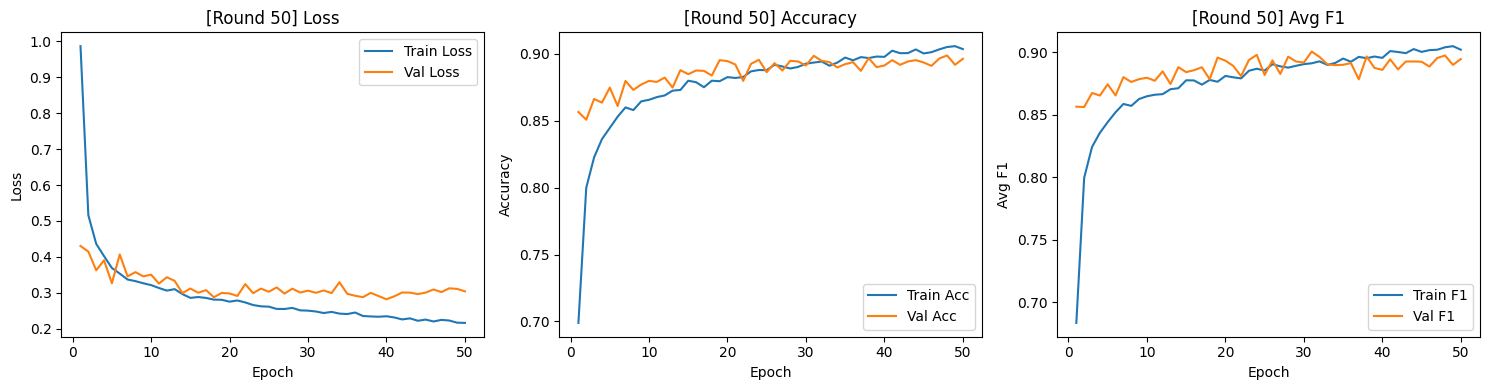

In [44]:
import torch.nn.functional as F


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight=None, smoothing=0.1):
        super().__init__()
        self.weight = weight
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        if self.weight is not None:
            loss = loss * self.weight[target]
        return loss.mean()

criterion = LabelSmoothingCrossEntropy(weight=class_weights, smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)


history = {
    "strategy": "Testing",
    "samples": [],
    "epoch_metrics": [],
    "round_val_acc": [],
    "round_val_avg_f1": []
}

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

epoch_stats = []
epochs=50
for ep in range(epochs):
    print(f"\nEpoch {ep+1}/{epochs}")

    tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train   | Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")

    val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, criterion)
    print(f"Val     | Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")

    epoch_stats.append({
        "train_loss": tr_loss,
        "train_acc": tr_acc,
        "train_avg_f1": tr_avgf1,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_avg_f1": val_avgf1
    })

    history["samples"].append(len(train_dataset))
    history["epoch_metrics"].append(epoch_stats)
    history["round_val_acc"].append(val_acc)
    history["round_val_avg_f1"].append(val_avgf1)

plot_round_metrics(history)


Class   GT     Pred   Acc      F1       IoU     
0       1816   1890   0.9185   0.9002   0.8184  
1       521    545    0.9098   0.8893   0.8007  
2       1663   1565   0.8677   0.8941   0.8084  

Total Accuracy: 0.8962
Macro F1 Score: 0.8945
Mean IoU:       0.8092


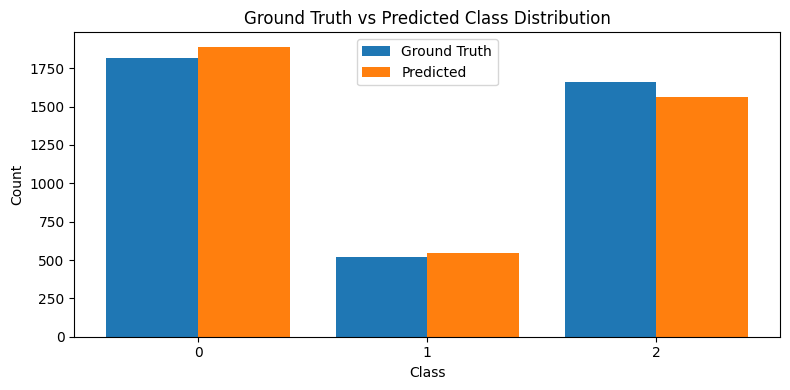

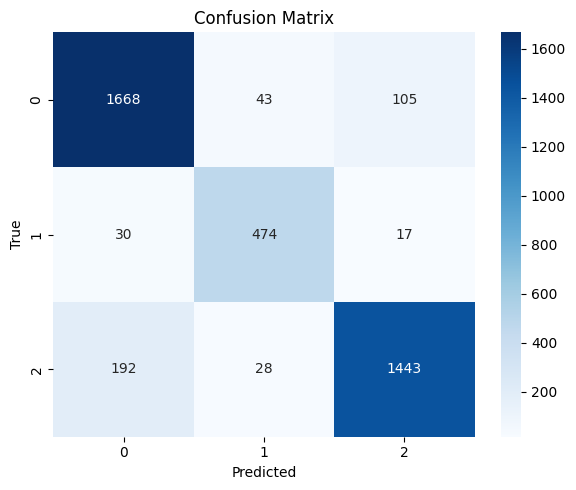

In [45]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_detailed(model, dataloader, device, num_classes):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, out = model(x)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    # Confusion matrix
    cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))

    # Metrics
    total_samples_per_class = np.bincount(targets, minlength=num_classes)
    predicted_samples_per_class = np.bincount(preds, minlength=num_classes)

    correct_per_class = np.diag(cm)
    acc_per_class = correct_per_class / (total_samples_per_class + 1e-6)
    f1_per_class = f1_score(targets, preds, average=None, labels=list(range(num_classes)))

    # IoU: TP / (TP + FP + FN)
    iou_per_class = []
    for c in range(num_classes):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0.0
        iou_per_class.append(iou)

    # Print table
    print(f"{'Class':<7} {'GT':<6} {'Pred':<6} {'Acc':<8} {'F1':<8} {'IoU':<8}")
    for c in range(num_classes):
        print(f"{c:<7} {total_samples_per_class[c]:<6} {predicted_samples_per_class[c]:<6} "
              f"{acc_per_class[c]:<8.4f} {f1_per_class[c]:<8.4f} {iou_per_class[c]:<8.4f}")

    # Summary metrics
    total_acc = np.mean(preds == targets)
    macro_f1 = np.mean(f1_per_class)
    mean_iou = np.mean(iou_per_class)

    print(f"\nTotal Accuracy: {total_acc:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Mean IoU:       {mean_iou:.4f}")

    # Histogram
    plt.figure(figsize=(8, 4))
    bar_width = 0.4
    indices = np.arange(num_classes)
    plt.bar(indices - bar_width/2, total_samples_per_class, width=bar_width, label="Ground Truth")
    plt.bar(indices + bar_width/2, predicted_samples_per_class, width=bar_width, label="Predicted")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Ground Truth vs Predicted Class Distribution")
    plt.xticks(indices)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


evaluate_detailed(model, val_loader, device, num_classes=3)